# Деревья решений

## Построение дерева

Опишем жадный алгоритм построения бинарного дерева решений:
1. Начинаем со всей обучающей выборки $X$, которую помещаем в корень $R_1$.
2. Задаём функционал качества $Q(X, j, t)$ и критерий остановки.
3. Запускаем построение из корня: $SplitNode(1, R_1)$

Функция $SplitNode(m, R_m)$
1. Если выполнен критерий остановки, то выход.
2. Находим наилучший с точки зрения $Q$ предикат: $j, t$: $[x_j<t]$
3. Помещаем предикат в вершину и получаем с его помощью разбиение $X$ на две части: $R_{left} = \lbrace x|x_j<t \rbrace$ и $R_{right} = \lbrace x|x_j \geqslant t \rbrace$
4. Поместим $R_{left}$ и $R_{right}$ соответсвенно в левое и правое поддерево.
5. Рекурсивно повторяем $SplitNode(left, R_{left})$ и $SplitNode(right, R_{right})$.

В конце поставим в соответствие каждому листу ответ. Для задачи классификации - это самый частый среди объектов класс или вектор с долями классов (можно интерпретировать как вероятности):
$$ c_v = \arg \max_{k\in Y} \sum_{(x_i,y_i) \in R_v} [y_i=k]  $$

## Функционал качества для деревьев решений


Энтропия Шеннона для системы с N возможными состояниями определяется по формуле:
$$H = - \sum_{i=0}^{N} p_i\log_2p_i $$

где $p_i$ – вероятности нахождения системы в $i$-ом состоянии.

Это очень важное понятие теории информации, которое позволяет оценить количество информации (степень хаоса в системе). Чем выше энтропия, тем менее упорядочена система и наоборот. С помощью энтропии мы формализуем функционал качества для разделение выборки (для задачи классификации).

In [ ]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt

import random
from pprint import pprint

from sklearn.model_selection import train_test_split

from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


Код для расчёта энтропии:

In [ ]:
def entropy(y):

    _, counts = np.unique(y, return_counts=True)

    probabilities = counts / counts.sum()
    entropy = sum(probabilities * -np.log2(probabilities))

    return entropy

Здесь $y$ - это массив значений целевой переменной

Энтропия – по сути степень хаоса (или неопределенности) в системе. Уменьшение энтропии называют приростом информации (information gain, IG).

Обочначим $R_v$ - объекты, которые нужно разделить в помощью предиката в вершине $v$. Запишем формулу для расчёта информационного прироста:
$$ Q = IG = H(R_v) - (H(R_{left})+H(R_{right}))$$

На каждом шаге нам нужно максимизировать этот функционал качества. Как это делать? Например, так можно перебрать $t$ для выбранного $j$.

Предыдущая версия формулы прироста информации слишком упрощена. В работе необходимо использовать более устойчивую формулу, которая учитывает не только энтропию подмножеств, но и их размер.

$$ Q = IG = H(R_v) - \Big (\frac{|R_{left}|} {|R_{v}|} H(R_{left})+ \frac{|R_{right}|} {|R_{v}|} H(R_{right})\Big)$$

где, $|R_{v}|$, $|R_{left}|$ и $|R_{right}|$ - количество элементов в соответствующих множествах.


### Задание 4.1

Реализуйте алгоритм построения дерева. Должны быть отдельные функции (методы) для расчёта энтропии (уже есть), для разделения узлов дерева (используйте, например, `pandas`), для подсчёта функционала качества $IG$, для выбора наилучшего разделения (с учетом признаков и порогов), для проверки критерия остановки.

Для набора данных `iris` реализуйте алгоритм и минимум три разных критерия остановки из перечисленных ниже:
* максимальной глубины дерева = 5
* минимального числа объектов в листе = 5
* максимальное количество листьев в дереве = 5
* purity (остановка, если все объекты в листе относятся к одному классу)

Реализуйте функцию `predict` (на вход функции подаётся датафрейм с объектами)

Оцените точность каждой модели с помощью метрики доля правильных ответов (`from sklearn.metrics import accuracy_score` или реализовать свою).

In [ ]:
from sklearn import datasets
iris = datasets.load_iris()
X_train, X_test, y_train, y_test = train_test_split(iris.data, iris.target, test_size = 0.33, random_state = 42)

from sklearn.metrics import accuracy_score
from sklearn.tree import DecisionTreeClassifier

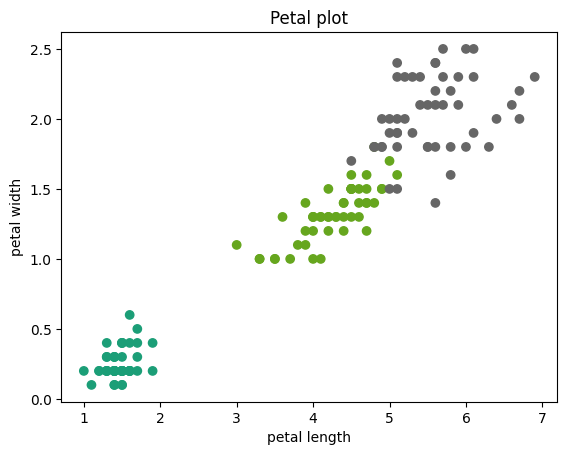

In [ ]:
plt.scatter(iris.data[:,2:3], iris.data[:,3:4], c=iris.target, cmap=plt.cm.Dark2)
plt.title('Petal plot')
plt.xlabel('petal length')
plt.ylabel('petal width')
plt.show()

In [ ]:
class Node:
  def __init__(self, distribution=None, depth=1):
    self.depth = depth
    self.distribution = distribution
    self.bad = False

  def make_node(self, distribution):
    return Node(distribution=distribution, depth=self.depth + 1)


class DecisionTree:
  def __init__(self, max_depth=5, min_leaf_objects_amount=2, max_leafs_amount=5):
    self.max_depth = max_depth
    self.min_leaf_objects_amount = min_leaf_objects_amount=5
    self.max_leafs_amount = max_leafs_amount
    self.leafs = 0

  def fit(self, X, y):
    self.y = y
    self.tree = Node(self._calculate_distribution(y))
    self._split(np.asarray(X), y, self.tree)

  def predict(self, X):
    return [np.argmax(self._predict_node(x, self.tree)) for x in X]

  def _calculate_distribution(self, y):
    return np.array([len(y[y == y_type]) / len(y) for y_type in set(self.y)])

  def _calculate_information_gain(self, r_v, r_left, r_right):
    return entropy(r_v) - ((len(r_left) / len(r_v) * entropy(r_left)) + (len(r_right) / len(r_v) * entropy(r_right)))

  def _split(self, X, y, node):
    if node.depth >= self.max_depth or self.leafs >= self.max_leafs_amount:
      node.bad = True
      self.leafs += 1
      return

    best_split_feature, best_threshold, best_ig = -1, -1, -1

    for feature, x_col in enumerate(X.T):
      for threshold in np.unique(x_col):
        left_part, right_part = y[x_col <= threshold], y[x_col > threshold]
        if len(left_part) == 0 or len(right_part) == 0:
          continue

        ig = self._calculate_information_gain(y, left_part, right_part)
        if ig > best_ig:
          best_threshold, best_ig = threshold, ig
          best_left_part, best_right_part = left_part, right_part
          best_split_feature = feature
          X_left = X[x_col <= best_threshold]
          X_right = X[x_col > best_threshold]

      if len(X_left) < self.min_leaf_objects_amount or len(X_right) < self.min_leaf_objects_amount or best_ig == 0:
        continue

    if len(X_left) < self.min_leaf_objects_amount or len(X_right) < self.min_leaf_objects_amount or best_ig == 0:
        node.bad = True
        self.leafs += 1
        return

    node.left = node.make_node(self._calculate_distribution(best_left_part))
    node.right = node.make_node(self._calculate_distribution(best_right_part))

    node.feature, node.threshold = best_split_feature, best_threshold
    self._split(X_left, best_left_part, node.left)
    self._split(X_right, best_right_part, node.right)

  def _predict_node(self, X, node):
    if node.bad:
      return node.distribution
    elif X[node.feature] > node.threshold:
      return self._predict_node(X, node.right)
    else:
      return self._predict_node(X, node.left)

In [ ]:
tree = DecisionTree()
tree.fit(X_train, y_train)

y_pred = tree.predict(X_test)
accuracy_score(y_test, y_pred)

0.98

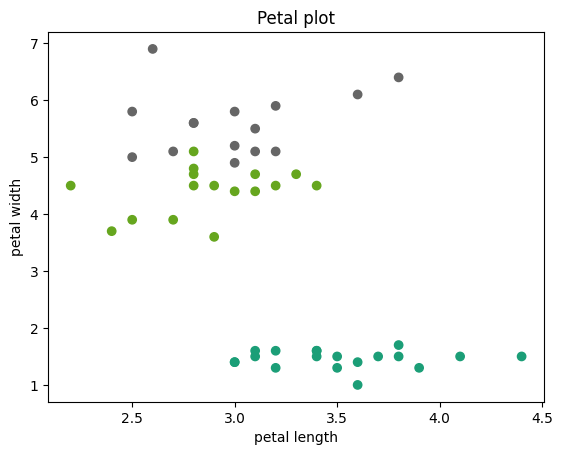

In [ ]:
plt.scatter(X_test[:, 1], X_test[:, 2], c=y_pred, cmap=plt.cm.Dark2)
plt.title('Petal plot')
plt.xlabel('petal length')
plt.ylabel('petal width')
plt.show()

In [ ]:
tree = DecisionTreeClassifier(max_depth=5, min_samples_leaf=5, max_leaf_nodes=5, criterion='entropy')
tree.fit(X_train, y_train)

y_pred = tree.predict(X_test)
accuracy_score(y_pred, y_test)

1.0

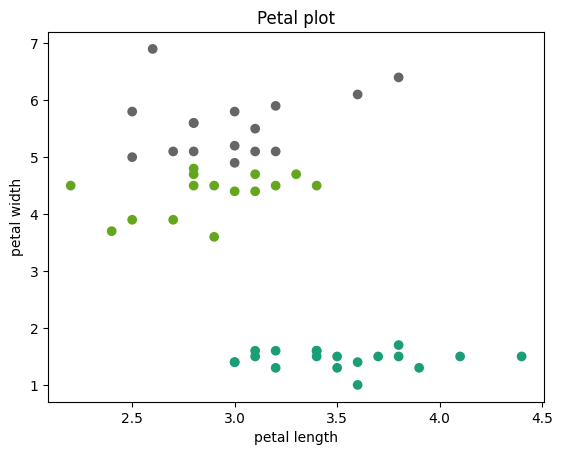

In [ ]:
plt.scatter(X_test[:, 1], X_test[:, 2], c=y_pred, cmap=plt.cm.Dark2)
plt.title('Petal plot')
plt.xlabel('petal length')
plt.ylabel('petal width')
plt.show()

Можем заметить, что наш метод получился чуть менее точным, чем метод sklearn, но он все еще дает неплохие результаты.

##  Случайный лес

Опишем алгоритм случайный лес (*random forest*) и попутно разберём основные идеи:

1. Зададим $N$ - число деревьев в лесу.
2. Для каждого $n$ из $N$ сгенерируем свою выборку $X_n$. Пусть $m$ - это количество объектов в $X$. При генерации каждой $X_n$ мы будем брать объекты $m$ раз с возвращением. То есть один и тот же объект может попасть в выборку несколько раз, а какие-то объекты не попадут. (Этот способ назвается бутстрап).
3. По каждой $X_n$ построим решающее дерево $b_n$. Обычно стараются делать глубокие деревья. В качестве критериев остановки можно использовать `max_depth` или `min_samples_leaf` (например, пока в каждом листе не окажется по одному объекту). При каждом разбиении сначала выбирается $k$ (эвристика $k = \sqrt d$, где $d$ - это число признаков объектов из выборки $X$) случайных признаков из исходных, и оптимальное разделение выборки ищется только среди них. Обратите внимание, что мы не выбрасываем оставшиеся признаки!
4. Итоговый алгоритм будет представлять собой результат голосования (для классификации) и среднее арифметическое (для регрессии). Модификация алгоритма предполагает учёт весов каждого отдельного слабого алгоритма в ансамбле, но в этом особо нет смысла.


### Задание 4.2

В качестве набора данных используйте: https://www.kaggle.com/mathchi/churn-for-bank-customers

Там есть описание и примеры работы с этими данными. Если кратко, речь идёт про задачу прогнозирования оттока клиентов. Есть данные о 10 тысячах клиентов банка, часть из которых больше не являются клиентами.

Используя либо свою реализацию, либо  `DecisionTreeClassifier` с разными настройками из `sklearn.tree` реализйте алгоритм "случайный лес".

Найдите наилучшие гиперпараметры этого алгоритма: количество деревьев, критерий остановки, функционал качества, минимальное количество объектов в листьях и другие.

Нельзя использовать готовую реализацию случайного леса из `sklearn`.

В подобных задачах очень важна интерпретируемость алгоритма. Попытайтесь оценить информативность признаков, т.е. ответить а вопрос, значения каких признаков являются самыми важными индикаторами того, что банк потеряет клиента.

In [ ]:
churn = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/Data/churn.csv', index_col='RowNumber')

In [ ]:
churn.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 10000 entries, 1 to 10000
Data columns (total 13 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   CustomerId       10000 non-null  int64  
 1   Surname          10000 non-null  object 
 2   CreditScore      10000 non-null  int64  
 3   Geography        10000 non-null  object 
 4   Gender           10000 non-null  object 
 5   Age              10000 non-null  int64  
 6   Tenure           10000 non-null  int64  
 7   Balance          10000 non-null  float64
 8   NumOfProducts    10000 non-null  int64  
 9   HasCrCard        10000 non-null  int64  
 10  IsActiveMember   10000 non-null  int64  
 11  EstimatedSalary  10000 non-null  float64
 12  Exited           10000 non-null  int64  
dtypes: float64(2), int64(8), object(3)
memory usage: 1.1+ MB


Очевидно, что id и фамилия клиента не оказывают никакого влияния на результат, поэтому отбросим их. Также переведем пол в int(bool)


In [ ]:
churn = churn.drop(['CustomerId', 'Surname'], axis=1)
churn.Gender = [int(x) for x in (churn.Gender == 'Male')]
churn

,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
RowNumber,,,,,,,,,,,
1,619,France,0,42,2,0.00,1,1,1,101348.88,1
2,608,Spain,0,41,1,83807.86,1,0,1,112542.58,0
3,502,France,0,42,8,159660.80,3,1,0,113931.57,1
4,699,France,0,39,1,0.00,2,0,0,93826.63,0
5,850,Spain,0,43,2,125510.82,1,1,1,79084.10,0
...,...,...,...,...,...,...,...,...,...,...,...
9996,771,France,1,39,5,0.00,2,1,0,96270.64,0
9997,516,France,1,35,10,57369.61,1,1,1,101699.77,0
9998,709,France,0,36,7,0.00,1,0,1,42085.58,1


In [ ]:
np.unique(churn.Geography)

In [ ]:
churn = pd.get_dummies(churn, columns=['Geography'])
churn

,CreditScore,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited,Geography_France,Geography_Germany,Geography_Spain
RowNumber,,,,,,,,,,,,,
1,619,0,42,2,0.00,1,1,1,101348.88,1,1,0,0
2,608,0,41,1,83807.86,1,0,1,112542.58,0,0,0,1
3,502,0,42,8,159660.80,3,1,0,113931.57,1,1,0,0
4,699,0,39,1,0.00,2,0,0,93826.63,0,1,0,0
5,850,0,43,2,125510.82,1,1,1,79084.10,0,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...
9996,771,1,39,5,0.00,2,1,0,96270.64,0,1,0,0
9997,516,1,35,10,57369.61,1,1,1,101699.77,0,1,0,0
9998,709,0,36,7,0.00,1,0,1,42085.58,1,1,0,0


In [ ]:
X, y = churn.drop('Exited', axis=1), churn.Exited
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42)

In [ ]:
class RandomForest:
  def __init__(self, amount_of_trees=100, max_depth=5, min_samples_leaf=5, criterion='entropy'):
    self.amount_of_trees = amount_of_trees
    self.max_depth = max_depth
    self.min_samples_leaf = min_samples_leaf
    self.criterion = criterion

  def fit(self, X, y):
    self.trees = []

    for _ in range(self.amount_of_trees):
      tree = DecisionTreeClassifier(max_depth=self.max_depth,
                                    min_samples_leaf=self.min_samples_leaf,
                                    criterion=self.criterion)

      X_n, y_n = self._bootstrap_split(X, y)
      tree.fit(X_n, y_n)
      self.trees.append(tree)

  def predict(self, X):
    votes = pd.DataFrame([tree.predict(X) for tree in self.trees])
    return round(votes.mean())

  def score(self, X, y):
    y_pred = self.predict(X)
    return accuracy_score(y, y_pred)

  def get_params(self, deep=True):
    return {'criterion' : self.criterion,
            'max_depth' : self.max_depth,
            'min_samples_leaf' : self.min_samples_leaf}

  def set_params(self, **parameters):
    for parameter, value in parameters.items():
      setattr(self, parameter, value)
    return self

  def _bootstrap_split(self, X, y):
    ids = np.random.choice(X.index, len(X), replace=True)
    return X.loc[ids], y.loc[ids]

In [ ]:
forest = RandomForest()
forest.fit(X_train, y_train)

y_pred = forest.predict(X_test)
y_pred.value_counts()

0.0    2975
1.0     325
dtype: int64

In [ ]:
round(accuracy_score(y_pred, y_test), 3)

0.865

Теперь найдем лучшие гиперпараметры нашего алгоритма

In [ ]:
best_score = -1
best_criterion = '-'
best_amount_of_trees = 0
best_max_depth = 0
best_min_samples_leaf = 0

for criterion in ['gini', 'entropy', 'log_loss']:
  for amount_of_trees in [10, 50, 100, 200]:
    for max_depth in range(4, 6):
      for min_samples_leaf in range(3, 6):
        forest = RandomForest(amount_of_trees=amount_of_trees, max_depth=max_depth, min_samples_leaf=min_samples_leaf, criterion=criterion)
        forest.fit(X_train, y_train)
        y_pred = forest.predict(X_test)

        if accuracy_score(y_pred, y_test) > best_score:
          best_score = accuracy_score(y_pred, y_test)

          best_criterion = criterion
          best_amount_of_trees = amount_of_trees
          best_max_depth = max_depth
          best_min_samples_leaf = min_samples_leaf

best_criterion, best_amount_of_trees, best_max_depth, best_min_samples_leaf, round(best_score, 3)

('log_loss', 10, 5, 3, 0.87)

Попробуем через GridSearchCV

In [ ]:
from sklearn.model_selection import GridSearchCV

simple_forest = RandomForest()
simple_forest.fit(X_train, y_train)

forest_params = {'criterion': ['gini', 'entropy'], 'amount_of_trees': [10, 50, 100], 'max_depth': np.arange(1, 7), 'min_samples_leaf': np.arange(1, 5)}
forest_grid = GridSearchCV(simple_forest, forest_params)

In [ ]:
%time
forest_grid.fit(X_train, y_train)

CPU times: user 4 µs, sys: 0 ns, total: 4 µs
Wall time: 7.63 µs


GridSearchCV(estimator=<__main__.RandomForest object at 0x792ce0795900>,
             param_grid={'amount_of_trees': [10, 50, 100],
                         'criterion': ['gini', 'entropy'],
                         'max_depth': array([1, 2, 3, 4, 5, 6]),
                         'min_samples_leaf': array([1, 2, 3, 4])})

In [ ]:
forest_grid.score(X_test, y_test)

0.87

In [ ]:
forest_grid.best_params_

{'amount_of_trees': 50,
 'criterion': 'gini',
 'max_depth': 6,
 'min_samples_leaf': 1}